In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.1.0


In [3]:
train = pd.read_csv("TIL_NLP_train_dataset.csv")
test = pd.read_csv("TIL_NLP_test_dataset.csv")
print(train.shape)
print(test.shape)

train_input = train["word_representation"]
train_labels = train[train.columns[2:]]
test_input = test["word_representation"]
test_id = test["id"]

print(train_input.head(1))
print(train_labels.head(1))
print(test_input.head(1))

(7380, 7)
(2460, 2)
0    w7718 w173355 w138132 w232277 w90685 w314686 w...
Name: word_representation, dtype: object
   outwear  top  trousers  women dresses  women skirts
0        1    0         1              0             0
0    w373517 w383437 w374393 w87179 w289496 w327385...
Name: word_representation, dtype: object


In [4]:
max_features = 100000
maxlen = 100
embed_size = 100

print('preprocessing start')

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_input) + list(test_input))

X_train1 = tokenizer.texts_to_sequences(train_input)
X_test1 = tokenizer.texts_to_sequences(test_input)
x_train_seq = sequence.pad_sequences(X_train1, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(X_test1, maxlen=maxlen)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

### Read pkl file provided
import gc
import pickle 
with open("word_embeddings.pkl",'rb') as g:
    embeddings_index = pickle.load(g)

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = len(word_index)+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print('preprocessing done')

preprocessing start
Found 4620 unique tokens.


/Users/ashleyho/opt/anaconda3/envs/BH2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


preprocessing done


In [18]:
filter_size = 6
max_pool_size = 4
max_pool_strides = 2
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

model = Sequential()
model.add(Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=train_embed))
model.add(Conv1D(filters = 256, kernel_size=6, padding='same', activation='relu',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Dropout(0.5))
model.add(Conv1D(filters = 128, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(BatchNormalization())
model.add(Conv1D(filters = 64, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Conv1D(filters = 32, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 16, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(BatchNormalization())
model.add(Conv1D(filters = 8, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         462100    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         196736    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          49216     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)         

In [19]:
import random
randomList = []
random.seed(2020)
# Set a length of the list to 10
for i in range(0, 150):
    # any random numbers from 0 to 1000
    randomList.append(random.randint(0, 7380))

x_val = x_train_seq[randomList]
y_val = train_labels.iloc[randomList]

In [20]:
model.compile(loss='binary_crossentropy', 
            optimizer='adam',
            metrics=['accuracy'])
            
batch_size = 128
epochs = 50
mod_path = '.Submission5'
mcp_save = ModelCheckpoint(mod_path, save_best_only=True, monitor='val_loss', mode='auto')

early_stopping_monitor = EarlyStopping(monitor='val_loss',  patience=10)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-8)


history = model.fit(x_train_seq, train_labels, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_val, y_val),verbose=1, shuffle = True,
                   callbacks=[early_stopping_monitor, mcp_save,reduce_lr])

Train on 7380 samples, validate on 150 samples
Epoch 1/50
7380/7380 [==============================] - 32s 4ms/sample - loss: 0.5174 - accuracy: 0.7213 - val_loss: 0.4506 - val_accuracy: 0.7880
Epoch 2/50
7380/7380 [==============================] - 18s 2ms/sample - loss: 0.3279 - accuracy: 0.8467 - val_loss: 0.5362 - val_accuracy: 0.7400
Epoch 3/50
7380/7380 [==============================] - 19s 3ms/sample - loss: 0.2200 - accuracy: 0.9192 - val_loss: 0.4609 - val_accuracy: 0.8013
Epoch 4/50
7380/7380 [==============================] - 27s 4ms/sample - loss: 0.1533 - accuracy: 0.9493 - val_loss: 0.2502 - val_accuracy: 0.9213
Epoch 5/50
7380/7380 [==============================] - 28s 4ms/sample - loss: 0.1161 - accuracy: 0.9640 - val_loss: 0.2184 - val_accuracy: 0.9307
Epoch 6/50
7380/7380 [==============================] - 27s 4ms/sample - loss: 0.0932 - accuracy: 0.9733 - val_loss: 0.1318 - val_accuracy: 0.9667
Epoch 7/50
7380/7380 [==============================] - 27s 4ms/sample 

In [21]:
model = tf.keras.models.load_model(mod_path)
y_pred_NN = model.predict(x_test_seq, verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


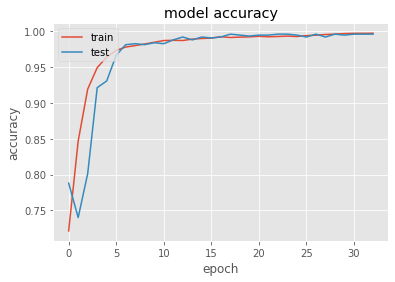

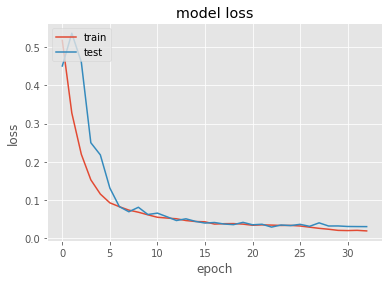

In [22]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words="english", analyzer='word', 
                             ngram_range=(1, 6), max_df=1.0, min_df=1, max_features=None)
cvect.fit(train_input)
x_train_vectorized = cvect.transform(train_input)
x_test_vectorized = cvect.transform(test_input)

print(x_train_vectorized.shape)
print(x_test_vectorized.shape)
print(train_labels.shape)

(7380, 330071)
(2460, 330071)
(7380, 5)


In [39]:
### SVC
clf1 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf2 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf3 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf4 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf5 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 

"outwear", "top", "trousers", "women dresses", "women skirts"
clf1.fit(x_train_vectorized, train_labels["outwear"])
clf2.fit(x_train_vectorized, train_labels["top"])
clf3.fit(x_train_vectorized, train_labels["trousers"])
clf4.fit(x_train_vectorized, train_labels["women dresses"])
clf5.fit(x_train_vectorized, train_labels["women skirts"])


y_pred1 = clf1.predict_proba(x_test_vectorized)[:, 1]
y_pred2 = clf2.predict_proba(x_test_vectorized)[:, 1]
y_pred3 = clf3.predict_proba(x_test_vectorized)[:, 1]
y_pred4 = clf4.predict_proba(x_test_vectorized)[:, 1]
y_pred5 = clf5.predict_proba(x_test_vectorized)[:, 1]

y_pred_class_svc = np.stack((y_pred1,y_pred2,y_pred3, y_pred4, y_pred5), axis = 1)

In [40]:
### CatBoost
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

ovr = OneVsRestClassifier(estimator=CatBoostClassifier(loss_function='MultiClass',eval_metric='AUC'
                                                       , verbose=1,learning_rate = 0.1,
                                                      iterations = 1000, rsm = 0.1))
ovr.fit(x_train_vectorized,train_labels)

y_pred_class_cbc = ovr.predict_proba(x_test_vectorized)

0:	total: 1.01s	remaining: 16m 52s
1:	total: 1.82s	remaining: 15m 8s
2:	total: 2.61s	remaining: 14m 26s
3:	total: 3.35s	remaining: 13m 54s
4:	total: 4.13s	remaining: 13m 40s
5:	total: 4.87s	remaining: 13m 26s
6:	total: 5.62s	remaining: 13m 17s
7:	total: 6.37s	remaining: 13m 9s
8:	total: 7.11s	remaining: 13m 3s
9:	total: 7.84s	remaining: 12m 56s
10:	total: 8.58s	remaining: 12m 51s
11:	total: 9.35s	remaining: 12m 49s
12:	total: 10.1s	remaining: 12m 47s
13:	total: 10.8s	remaining: 12m 43s
14:	total: 11.6s	remaining: 12m 40s
15:	total: 12.3s	remaining: 12m 37s
16:	total: 13.1s	remaining: 12m 35s
17:	total: 13.8s	remaining: 12m 32s
18:	total: 14.6s	remaining: 12m 31s
19:	total: 15.4s	remaining: 12m 32s
20:	total: 16.1s	remaining: 12m 31s
21:	total: 16.9s	remaining: 12m 29s
22:	total: 17.6s	remaining: 12m 29s
23:	total: 18.4s	remaining: 12m 28s
24:	total: 19.2s	remaining: 12m 28s
25:	total: 19.9s	remaining: 12m 27s
26:	total: 20.7s	remaining: 12m 25s
27:	total: 21.4s	remaining: 12m 24s
28:	t

224:	total: 2m 51s	remaining: 9m 52s
225:	total: 2m 52s	remaining: 9m 51s
226:	total: 2m 53s	remaining: 9m 50s
227:	total: 2m 54s	remaining: 9m 50s
228:	total: 2m 55s	remaining: 9m 49s
229:	total: 2m 55s	remaining: 9m 48s
230:	total: 2m 56s	remaining: 9m 47s
231:	total: 2m 57s	remaining: 9m 47s
232:	total: 2m 58s	remaining: 9m 46s
233:	total: 2m 58s	remaining: 9m 45s
234:	total: 2m 59s	remaining: 9m 44s
235:	total: 3m	remaining: 9m 44s
236:	total: 3m 1s	remaining: 9m 43s
237:	total: 3m 1s	remaining: 9m 42s
238:	total: 3m 2s	remaining: 9m 41s
239:	total: 3m 3s	remaining: 9m 41s
240:	total: 3m 4s	remaining: 9m 40s
241:	total: 3m 5s	remaining: 9m 39s
242:	total: 3m 5s	remaining: 9m 38s
243:	total: 3m 6s	remaining: 9m 38s
244:	total: 3m 7s	remaining: 9m 37s
245:	total: 3m 8s	remaining: 9m 36s
246:	total: 3m 8s	remaining: 9m 36s
247:	total: 3m 9s	remaining: 9m 35s
248:	total: 3m 10s	remaining: 9m 34s
249:	total: 3m 11s	remaining: 9m 33s
250:	total: 3m 12s	remaining: 9m 32s
251:	total: 3m 12

449:	total: 5m 41s	remaining: 6m 57s
450:	total: 5m 42s	remaining: 6m 56s
451:	total: 5m 43s	remaining: 6m 55s
452:	total: 5m 43s	remaining: 6m 55s
453:	total: 5m 44s	remaining: 6m 54s
454:	total: 5m 45s	remaining: 6m 53s
455:	total: 5m 46s	remaining: 6m 52s
456:	total: 5m 46s	remaining: 6m 52s
457:	total: 5m 47s	remaining: 6m 51s
458:	total: 5m 48s	remaining: 6m 50s
459:	total: 5m 49s	remaining: 6m 49s
460:	total: 5m 49s	remaining: 6m 48s
461:	total: 5m 50s	remaining: 6m 48s
462:	total: 5m 51s	remaining: 6m 47s
463:	total: 5m 52s	remaining: 6m 46s
464:	total: 5m 52s	remaining: 6m 45s
465:	total: 5m 53s	remaining: 6m 45s
466:	total: 5m 54s	remaining: 6m 44s
467:	total: 5m 55s	remaining: 6m 43s
468:	total: 5m 55s	remaining: 6m 42s
469:	total: 5m 56s	remaining: 6m 42s
470:	total: 5m 57s	remaining: 6m 41s
471:	total: 5m 58s	remaining: 6m 40s
472:	total: 5m 58s	remaining: 6m 39s
473:	total: 5m 59s	remaining: 6m 38s
474:	total: 6m	remaining: 6m 38s
475:	total: 6m 1s	remaining: 6m 37s
476:	t

674:	total: 8m 32s	remaining: 4m 6s
675:	total: 8m 32s	remaining: 4m 5s
676:	total: 8m 33s	remaining: 4m 5s
677:	total: 8m 34s	remaining: 4m 4s
678:	total: 8m 35s	remaining: 4m 3s
679:	total: 8m 35s	remaining: 4m 2s
680:	total: 8m 36s	remaining: 4m 1s
681:	total: 8m 37s	remaining: 4m 1s
682:	total: 8m 38s	remaining: 4m
683:	total: 8m 38s	remaining: 3m 59s
684:	total: 8m 39s	remaining: 3m 58s
685:	total: 8m 40s	remaining: 3m 58s
686:	total: 8m 41s	remaining: 3m 57s
687:	total: 8m 41s	remaining: 3m 56s
688:	total: 8m 42s	remaining: 3m 55s
689:	total: 8m 43s	remaining: 3m 55s
690:	total: 8m 43s	remaining: 3m 54s
691:	total: 8m 44s	remaining: 3m 53s
692:	total: 8m 45s	remaining: 3m 52s
693:	total: 8m 46s	remaining: 3m 52s
694:	total: 8m 46s	remaining: 3m 51s
695:	total: 8m 47s	remaining: 3m 50s
696:	total: 8m 48s	remaining: 3m 49s
697:	total: 8m 49s	remaining: 3m 48s
698:	total: 8m 49s	remaining: 3m 48s
699:	total: 8m 50s	remaining: 3m 47s
700:	total: 8m 51s	remaining: 3m 46s
701:	total: 8

896:	total: 11m 16s	remaining: 1m 17s
897:	total: 11m 17s	remaining: 1m 16s
898:	total: 11m 18s	remaining: 1m 16s
899:	total: 11m 18s	remaining: 1m 15s
900:	total: 11m 19s	remaining: 1m 14s
901:	total: 11m 20s	remaining: 1m 13s
902:	total: 11m 21s	remaining: 1m 13s
903:	total: 11m 21s	remaining: 1m 12s
904:	total: 11m 22s	remaining: 1m 11s
905:	total: 11m 23s	remaining: 1m 10s
906:	total: 11m 23s	remaining: 1m 10s
907:	total: 11m 24s	remaining: 1m 9s
908:	total: 11m 25s	remaining: 1m 8s
909:	total: 11m 26s	remaining: 1m 7s
910:	total: 11m 26s	remaining: 1m 7s
911:	total: 11m 27s	remaining: 1m 6s
912:	total: 11m 28s	remaining: 1m 5s
913:	total: 11m 29s	remaining: 1m 4s
914:	total: 11m 29s	remaining: 1m 4s
915:	total: 11m 30s	remaining: 1m 3s
916:	total: 11m 31s	remaining: 1m 2s
917:	total: 11m 32s	remaining: 1m 1s
918:	total: 11m 32s	remaining: 1m 1s
919:	total: 11m 33s	remaining: 1m
920:	total: 11m 34s	remaining: 59.6s
921:	total: 11m 35s	remaining: 58.8s
922:	total: 11m 35s	remaining:

122:	total: 1m 32s	remaining: 10m 57s
123:	total: 1m 32s	remaining: 10m 56s
124:	total: 1m 33s	remaining: 10m 56s
125:	total: 1m 34s	remaining: 10m 55s
126:	total: 1m 35s	remaining: 10m 54s
127:	total: 1m 35s	remaining: 10m 53s
128:	total: 1m 36s	remaining: 10m 53s
129:	total: 1m 37s	remaining: 10m 52s
130:	total: 1m 38s	remaining: 10m 51s
131:	total: 1m 38s	remaining: 10m 50s
132:	total: 1m 39s	remaining: 10m 49s
133:	total: 1m 40s	remaining: 10m 49s
134:	total: 1m 41s	remaining: 10m 48s
135:	total: 1m 41s	remaining: 10m 47s
136:	total: 1m 42s	remaining: 10m 46s
137:	total: 1m 43s	remaining: 10m 46s
138:	total: 1m 44s	remaining: 10m 45s
139:	total: 1m 44s	remaining: 10m 44s
140:	total: 1m 45s	remaining: 10m 43s
141:	total: 1m 46s	remaining: 10m 42s
142:	total: 1m 47s	remaining: 10m 42s
143:	total: 1m 47s	remaining: 10m 41s
144:	total: 1m 48s	remaining: 10m 40s
145:	total: 1m 49s	remaining: 10m 40s
146:	total: 1m 50s	remaining: 10m 39s
147:	total: 1m 50s	remaining: 10m 38s
148:	total: 

344:	total: 4m 18s	remaining: 8m 10s
345:	total: 4m 19s	remaining: 8m 9s
346:	total: 4m 19s	remaining: 8m 8s
347:	total: 4m 20s	remaining: 8m 8s
348:	total: 4m 21s	remaining: 8m 7s
349:	total: 4m 22s	remaining: 8m 6s
350:	total: 4m 22s	remaining: 8m 5s
351:	total: 4m 23s	remaining: 8m 5s
352:	total: 4m 24s	remaining: 8m 4s
353:	total: 4m 25s	remaining: 8m 3s
354:	total: 4m 25s	remaining: 8m 2s
355:	total: 4m 26s	remaining: 8m 2s
356:	total: 4m 27s	remaining: 8m 1s
357:	total: 4m 28s	remaining: 8m
358:	total: 4m 28s	remaining: 7m 59s
359:	total: 4m 29s	remaining: 7m 59s
360:	total: 4m 30s	remaining: 7m 58s
361:	total: 4m 31s	remaining: 7m 57s
362:	total: 4m 31s	remaining: 7m 56s
363:	total: 4m 32s	remaining: 7m 56s
364:	total: 4m 33s	remaining: 7m 55s
365:	total: 4m 34s	remaining: 7m 54s
366:	total: 4m 34s	remaining: 7m 53s
367:	total: 4m 35s	remaining: 7m 53s
368:	total: 4m 36s	remaining: 7m 52s
369:	total: 4m 36s	remaining: 7m 51s
370:	total: 4m 37s	remaining: 7m 50s
371:	total: 4m 38

569:	total: 7m 10s	remaining: 5m 25s
570:	total: 7m 10s	remaining: 5m 24s
571:	total: 7m 11s	remaining: 5m 23s
572:	total: 7m 12s	remaining: 5m 22s
573:	total: 7m 13s	remaining: 5m 22s
574:	total: 7m 13s	remaining: 5m 21s
575:	total: 7m 14s	remaining: 5m 20s
576:	total: 7m 15s	remaining: 5m 19s
577:	total: 7m 16s	remaining: 5m 19s
578:	total: 7m 17s	remaining: 5m 18s
579:	total: 7m 17s	remaining: 5m 17s
580:	total: 7m 18s	remaining: 5m 16s
581:	total: 7m 19s	remaining: 5m 16s
582:	total: 7m 20s	remaining: 5m 15s
583:	total: 7m 20s	remaining: 5m 14s
584:	total: 7m 21s	remaining: 5m 13s
585:	total: 7m 22s	remaining: 5m 13s
586:	total: 7m 23s	remaining: 5m 12s
587:	total: 7m 24s	remaining: 5m 11s
588:	total: 7m 25s	remaining: 5m 11s
589:	total: 7m 25s	remaining: 5m 10s
590:	total: 7m 26s	remaining: 5m 9s
591:	total: 7m 27s	remaining: 5m 8s
592:	total: 7m 28s	remaining: 5m 8s
593:	total: 7m 28s	remaining: 5m 7s
594:	total: 7m 29s	remaining: 5m 6s
595:	total: 7m 30s	remaining: 5m 5s
596:	to

793:	total: 10m 2s	remaining: 2m 36s
794:	total: 10m 2s	remaining: 2m 35s
795:	total: 10m 3s	remaining: 2m 34s
796:	total: 10m 4s	remaining: 2m 34s
797:	total: 10m 4s	remaining: 2m 33s
798:	total: 10m 5s	remaining: 2m 32s
799:	total: 10m 6s	remaining: 2m 31s
800:	total: 10m 7s	remaining: 2m 31s
801:	total: 10m 7s	remaining: 2m 30s
802:	total: 10m 8s	remaining: 2m 29s
803:	total: 10m 9s	remaining: 2m 28s
804:	total: 10m 10s	remaining: 2m 27s
805:	total: 10m 10s	remaining: 2m 27s
806:	total: 10m 11s	remaining: 2m 26s
807:	total: 10m 12s	remaining: 2m 25s
808:	total: 10m 13s	remaining: 2m 24s
809:	total: 10m 13s	remaining: 2m 24s
810:	total: 10m 14s	remaining: 2m 23s
811:	total: 10m 15s	remaining: 2m 22s
812:	total: 10m 16s	remaining: 2m 21s
813:	total: 10m 17s	remaining: 2m 21s
814:	total: 10m 17s	remaining: 2m 20s
815:	total: 10m 18s	remaining: 2m 19s
816:	total: 10m 19s	remaining: 2m 18s
817:	total: 10m 20s	remaining: 2m 18s
818:	total: 10m 21s	remaining: 2m 17s
819:	total: 10m 21s	rem

15:	total: 12.2s	remaining: 12m 30s
16:	total: 13s	remaining: 12m 29s
17:	total: 13.7s	remaining: 12m 29s
18:	total: 14.5s	remaining: 12m 29s
19:	total: 15.3s	remaining: 12m 28s
20:	total: 16s	remaining: 12m 27s
21:	total: 16.8s	remaining: 12m 26s
22:	total: 17.6s	remaining: 12m 25s
23:	total: 18.3s	remaining: 12m 25s
24:	total: 19.1s	remaining: 12m 24s
25:	total: 19.8s	remaining: 12m 23s
26:	total: 20.6s	remaining: 12m 22s
27:	total: 21.4s	remaining: 12m 21s
28:	total: 22.1s	remaining: 12m 21s
29:	total: 22.9s	remaining: 12m 20s
30:	total: 23.7s	remaining: 12m 19s
31:	total: 24.4s	remaining: 12m 18s
32:	total: 25.2s	remaining: 12m 17s
33:	total: 25.9s	remaining: 12m 16s
34:	total: 26.7s	remaining: 12m 15s
35:	total: 27.5s	remaining: 12m 15s
36:	total: 28.3s	remaining: 12m 16s
37:	total: 29.1s	remaining: 12m 15s
38:	total: 29.8s	remaining: 12m 14s
39:	total: 30.6s	remaining: 12m 14s
40:	total: 31.4s	remaining: 12m 13s
41:	total: 32.1s	remaining: 12m 12s
42:	total: 32.9s	remaining: 12m 

238:	total: 3m 2s	remaining: 9m 41s
239:	total: 3m 3s	remaining: 9m 40s
240:	total: 3m 3s	remaining: 9m 39s
241:	total: 3m 4s	remaining: 9m 38s
242:	total: 3m 5s	remaining: 9m 37s
243:	total: 3m 6s	remaining: 9m 36s
244:	total: 3m 6s	remaining: 9m 36s
245:	total: 3m 7s	remaining: 9m 35s
246:	total: 3m 8s	remaining: 9m 34s
247:	total: 3m 9s	remaining: 9m 33s
248:	total: 3m 9s	remaining: 9m 32s
249:	total: 3m 10s	remaining: 9m 31s
250:	total: 3m 11s	remaining: 9m 30s
251:	total: 3m 12s	remaining: 9m 30s
252:	total: 3m 12s	remaining: 9m 29s
253:	total: 3m 13s	remaining: 9m 28s
254:	total: 3m 14s	remaining: 9m 27s
255:	total: 3m 15s	remaining: 9m 26s
256:	total: 3m 15s	remaining: 9m 25s
257:	total: 3m 16s	remaining: 9m 25s
258:	total: 3m 17s	remaining: 9m 24s
259:	total: 3m 17s	remaining: 9m 23s
260:	total: 3m 18s	remaining: 9m 22s
261:	total: 3m 19s	remaining: 9m 21s
262:	total: 3m 20s	remaining: 9m 20s
263:	total: 3m 20s	remaining: 9m 20s
264:	total: 3m 21s	remaining: 9m 19s
265:	total: 

463:	total: 5m 49s	remaining: 6m 44s
464:	total: 5m 50s	remaining: 6m 43s
465:	total: 5m 51s	remaining: 6m 42s
466:	total: 5m 52s	remaining: 6m 41s
467:	total: 5m 52s	remaining: 6m 41s
468:	total: 5m 53s	remaining: 6m 40s
469:	total: 5m 54s	remaining: 6m 39s
470:	total: 5m 55s	remaining: 6m 38s
471:	total: 5m 56s	remaining: 6m 38s
472:	total: 5m 56s	remaining: 6m 37s
473:	total: 5m 57s	remaining: 6m 36s
474:	total: 5m 58s	remaining: 6m 35s
475:	total: 5m 59s	remaining: 6m 35s
476:	total: 5m 59s	remaining: 6m 34s
477:	total: 6m	remaining: 6m 33s
478:	total: 6m 1s	remaining: 6m 32s
479:	total: 6m 2s	remaining: 6m 32s
480:	total: 6m 2s	remaining: 6m 31s
481:	total: 6m 3s	remaining: 6m 30s
482:	total: 6m 4s	remaining: 6m 29s
483:	total: 6m 5s	remaining: 6m 29s
484:	total: 6m 5s	remaining: 6m 28s
485:	total: 6m 6s	remaining: 6m 27s
486:	total: 6m 7s	remaining: 6m 26s
487:	total: 6m 8s	remaining: 6m 26s
488:	total: 6m 8s	remaining: 6m 25s
489:	total: 6m 9s	remaining: 6m 24s
490:	total: 6m 10

688:	total: 8m 39s	remaining: 3m 54s
689:	total: 8m 40s	remaining: 3m 53s
690:	total: 8m 41s	remaining: 3m 53s
691:	total: 8m 42s	remaining: 3m 52s
692:	total: 8m 42s	remaining: 3m 51s
693:	total: 8m 43s	remaining: 3m 50s
694:	total: 8m 44s	remaining: 3m 50s
695:	total: 8m 45s	remaining: 3m 49s
696:	total: 8m 45s	remaining: 3m 48s
697:	total: 8m 46s	remaining: 3m 47s
698:	total: 8m 47s	remaining: 3m 47s
699:	total: 8m 48s	remaining: 3m 46s
700:	total: 8m 48s	remaining: 3m 45s
701:	total: 8m 49s	remaining: 3m 44s
702:	total: 8m 50s	remaining: 3m 44s
703:	total: 8m 51s	remaining: 3m 43s
704:	total: 8m 51s	remaining: 3m 42s
705:	total: 8m 52s	remaining: 3m 41s
706:	total: 8m 53s	remaining: 3m 41s
707:	total: 8m 54s	remaining: 3m 40s
708:	total: 8m 54s	remaining: 3m 39s
709:	total: 8m 55s	remaining: 3m 38s
710:	total: 8m 56s	remaining: 3m 38s
711:	total: 8m 57s	remaining: 3m 37s
712:	total: 8m 57s	remaining: 3m 36s
713:	total: 8m 58s	remaining: 3m 35s
714:	total: 8m 59s	remaining: 3m 34s
7

909:	total: 11m 25s	remaining: 1m 7s
910:	total: 11m 26s	remaining: 1m 7s
911:	total: 11m 27s	remaining: 1m 6s
912:	total: 11m 28s	remaining: 1m 5s
913:	total: 11m 28s	remaining: 1m 4s
914:	total: 11m 29s	remaining: 1m 4s
915:	total: 11m 30s	remaining: 1m 3s
916:	total: 11m 31s	remaining: 1m 2s
917:	total: 11m 31s	remaining: 1m 1s
918:	total: 11m 32s	remaining: 1m 1s
919:	total: 11m 33s	remaining: 1m
920:	total: 11m 34s	remaining: 59.5s
921:	total: 11m 34s	remaining: 58.8s
922:	total: 11m 35s	remaining: 58s
923:	total: 11m 36s	remaining: 57.3s
924:	total: 11m 37s	remaining: 56.5s
925:	total: 11m 37s	remaining: 55.8s
926:	total: 11m 38s	remaining: 55s
927:	total: 11m 39s	remaining: 54.3s
928:	total: 11m 40s	remaining: 53.5s
929:	total: 11m 40s	remaining: 52.8s
930:	total: 11m 41s	remaining: 52s
931:	total: 11m 42s	remaining: 51.3s
932:	total: 11m 43s	remaining: 50.5s
933:	total: 11m 43s	remaining: 49.7s
934:	total: 11m 44s	remaining: 49s
935:	total: 11m 45s	remaining: 48.2s
936:	total: 

135:	total: 1m 46s	remaining: 11m 14s
136:	total: 1m 47s	remaining: 11m 14s
137:	total: 1m 47s	remaining: 11m 13s
138:	total: 1m 48s	remaining: 11m 12s
139:	total: 1m 49s	remaining: 11m 11s
140:	total: 1m 50s	remaining: 11m 11s
141:	total: 1m 50s	remaining: 11m 10s
142:	total: 1m 51s	remaining: 11m 9s
143:	total: 1m 52s	remaining: 11m 8s
144:	total: 1m 53s	remaining: 11m 7s
145:	total: 1m 54s	remaining: 11m 7s
146:	total: 1m 54s	remaining: 11m 6s
147:	total: 1m 55s	remaining: 11m 6s
148:	total: 1m 56s	remaining: 11m 5s
149:	total: 1m 57s	remaining: 11m 4s
150:	total: 1m 58s	remaining: 11m 3s
151:	total: 1m 58s	remaining: 11m 2s
152:	total: 1m 59s	remaining: 11m 2s
153:	total: 2m	remaining: 11m 1s
154:	total: 2m 1s	remaining: 11m
155:	total: 2m 1s	remaining: 10m 59s
156:	total: 2m 2s	remaining: 10m 58s
157:	total: 2m 3s	remaining: 10m 58s
158:	total: 2m 4s	remaining: 10m 57s
159:	total: 2m 5s	remaining: 10m 56s
160:	total: 2m 5s	remaining: 10m 55s
161:	total: 2m 6s	remaining: 10m 55s
16

357:	total: 4m 37s	remaining: 8m 17s
358:	total: 4m 38s	remaining: 8m 16s
359:	total: 4m 38s	remaining: 8m 15s
360:	total: 4m 39s	remaining: 8m 15s
361:	total: 4m 40s	remaining: 8m 14s
362:	total: 4m 41s	remaining: 8m 13s
363:	total: 4m 42s	remaining: 8m 12s
364:	total: 4m 42s	remaining: 8m 12s
365:	total: 4m 43s	remaining: 8m 11s
366:	total: 4m 44s	remaining: 8m 10s
367:	total: 4m 45s	remaining: 8m 9s
368:	total: 4m 45s	remaining: 8m 8s
369:	total: 4m 46s	remaining: 8m 8s
370:	total: 4m 47s	remaining: 8m 7s
371:	total: 4m 48s	remaining: 8m 6s
372:	total: 4m 49s	remaining: 8m 5s
373:	total: 4m 49s	remaining: 8m 5s
374:	total: 4m 50s	remaining: 8m 4s
375:	total: 4m 51s	remaining: 8m 3s
376:	total: 4m 52s	remaining: 8m 2s
377:	total: 4m 53s	remaining: 8m 2s
378:	total: 4m 53s	remaining: 8m 1s
379:	total: 4m 54s	remaining: 8m
380:	total: 4m 55s	remaining: 7m 59s
381:	total: 4m 56s	remaining: 7m 59s
382:	total: 4m 56s	remaining: 7m 58s
383:	total: 4m 57s	remaining: 7m 57s
384:	total: 4m 58

582:	total: 7m 33s	remaining: 5m 24s
583:	total: 7m 34s	remaining: 5m 23s
584:	total: 7m 34s	remaining: 5m 22s
585:	total: 7m 35s	remaining: 5m 21s
586:	total: 7m 36s	remaining: 5m 21s
587:	total: 7m 37s	remaining: 5m 20s
588:	total: 7m 37s	remaining: 5m 19s
589:	total: 7m 38s	remaining: 5m 18s
590:	total: 7m 39s	remaining: 5m 17s
591:	total: 7m 40s	remaining: 5m 17s
592:	total: 7m 41s	remaining: 5m 16s
593:	total: 7m 41s	remaining: 5m 15s
594:	total: 7m 42s	remaining: 5m 14s
595:	total: 7m 43s	remaining: 5m 14s
596:	total: 7m 44s	remaining: 5m 13s
597:	total: 7m 44s	remaining: 5m 12s
598:	total: 7m 45s	remaining: 5m 11s
599:	total: 7m 46s	remaining: 5m 10s
600:	total: 7m 47s	remaining: 5m 10s
601:	total: 7m 48s	remaining: 5m 9s
602:	total: 7m 48s	remaining: 5m 8s
603:	total: 7m 49s	remaining: 5m 7s
604:	total: 7m 50s	remaining: 5m 7s
605:	total: 7m 51s	remaining: 5m 6s
606:	total: 7m 51s	remaining: 5m 5s
607:	total: 7m 52s	remaining: 5m 4s
608:	total: 7m 53s	remaining: 5m 4s
609:	tota

806:	total: 10m 24s	remaining: 2m 29s
807:	total: 10m 25s	remaining: 2m 28s
808:	total: 10m 26s	remaining: 2m 27s
809:	total: 10m 27s	remaining: 2m 27s
810:	total: 10m 27s	remaining: 2m 26s
811:	total: 10m 28s	remaining: 2m 25s
812:	total: 10m 29s	remaining: 2m 24s
813:	total: 10m 30s	remaining: 2m 23s
814:	total: 10m 30s	remaining: 2m 23s
815:	total: 10m 31s	remaining: 2m 22s
816:	total: 10m 32s	remaining: 2m 21s
817:	total: 10m 33s	remaining: 2m 20s
818:	total: 10m 34s	remaining: 2m 20s
819:	total: 10m 34s	remaining: 2m 19s
820:	total: 10m 35s	remaining: 2m 18s
821:	total: 10m 36s	remaining: 2m 17s
822:	total: 10m 37s	remaining: 2m 17s
823:	total: 10m 38s	remaining: 2m 16s
824:	total: 10m 38s	remaining: 2m 15s
825:	total: 10m 39s	remaining: 2m 14s
826:	total: 10m 40s	remaining: 2m 13s
827:	total: 10m 41s	remaining: 2m 13s
828:	total: 10m 41s	remaining: 2m 12s
829:	total: 10m 42s	remaining: 2m 11s
830:	total: 10m 43s	remaining: 2m 10s
831:	total: 10m 44s	remaining: 2m 10s
832:	total: 

29:	total: 23.8s	remaining: 12m 48s
30:	total: 24.6s	remaining: 12m 48s
31:	total: 25.4s	remaining: 12m 47s
32:	total: 26.1s	remaining: 12m 45s
33:	total: 26.9s	remaining: 12m 45s
34:	total: 27.8s	remaining: 12m 45s
35:	total: 28.5s	remaining: 12m 44s
36:	total: 29.3s	remaining: 12m 42s
37:	total: 30.1s	remaining: 12m 42s
38:	total: 30.9s	remaining: 12m 42s
39:	total: 31.7s	remaining: 12m 41s
40:	total: 32.5s	remaining: 12m 40s
41:	total: 33.3s	remaining: 12m 40s
42:	total: 34.1s	remaining: 12m 39s
43:	total: 34.9s	remaining: 12m 38s
44:	total: 35.7s	remaining: 12m 37s
45:	total: 36.5s	remaining: 12m 37s
46:	total: 37.3s	remaining: 12m 36s
47:	total: 38.1s	remaining: 12m 35s
48:	total: 38.9s	remaining: 12m 34s
49:	total: 39.7s	remaining: 12m 33s
50:	total: 40.5s	remaining: 12m 33s
51:	total: 41.3s	remaining: 12m 32s
52:	total: 42.1s	remaining: 12m 31s
53:	total: 42.9s	remaining: 12m 30s
54:	total: 43.6s	remaining: 12m 29s
55:	total: 44.5s	remaining: 12m 29s
56:	total: 45.3s	remaining: 

251:	total: 3m 19s	remaining: 9m 51s
252:	total: 3m 20s	remaining: 9m 51s
253:	total: 3m 21s	remaining: 9m 50s
254:	total: 3m 21s	remaining: 9m 49s
255:	total: 3m 22s	remaining: 9m 49s
256:	total: 3m 23s	remaining: 9m 48s
257:	total: 3m 24s	remaining: 9m 47s
258:	total: 3m 25s	remaining: 9m 46s
259:	total: 3m 25s	remaining: 9m 46s
260:	total: 3m 26s	remaining: 9m 45s
261:	total: 3m 27s	remaining: 9m 44s
262:	total: 3m 28s	remaining: 9m 43s
263:	total: 3m 28s	remaining: 9m 42s
264:	total: 3m 29s	remaining: 9m 41s
265:	total: 3m 30s	remaining: 9m 40s
266:	total: 3m 31s	remaining: 9m 40s
267:	total: 3m 32s	remaining: 9m 39s
268:	total: 3m 32s	remaining: 9m 38s
269:	total: 3m 33s	remaining: 9m 38s
270:	total: 3m 34s	remaining: 9m 37s
271:	total: 3m 35s	remaining: 9m 36s
272:	total: 3m 36s	remaining: 9m 36s
273:	total: 3m 37s	remaining: 9m 35s
274:	total: 3m 37s	remaining: 9m 34s
275:	total: 3m 38s	remaining: 9m 33s
276:	total: 3m 39s	remaining: 9m 32s
277:	total: 3m 40s	remaining: 9m 32s
2

476:	total: 6m 19s	remaining: 6m 56s
477:	total: 6m 20s	remaining: 6m 55s
478:	total: 6m 21s	remaining: 6m 54s
479:	total: 6m 22s	remaining: 6m 54s
480:	total: 6m 23s	remaining: 6m 53s
481:	total: 6m 23s	remaining: 6m 52s
482:	total: 6m 24s	remaining: 6m 51s
483:	total: 6m 25s	remaining: 6m 50s
484:	total: 6m 26s	remaining: 6m 50s
485:	total: 6m 26s	remaining: 6m 49s
486:	total: 6m 27s	remaining: 6m 48s
487:	total: 6m 28s	remaining: 6m 47s
488:	total: 6m 29s	remaining: 6m 46s
489:	total: 6m 30s	remaining: 6m 46s
490:	total: 6m 30s	remaining: 6m 45s
491:	total: 6m 31s	remaining: 6m 44s
492:	total: 6m 32s	remaining: 6m 43s
493:	total: 6m 33s	remaining: 6m 42s
494:	total: 6m 34s	remaining: 6m 42s
495:	total: 6m 34s	remaining: 6m 41s
496:	total: 6m 35s	remaining: 6m 40s
497:	total: 6m 36s	remaining: 6m 39s
498:	total: 6m 37s	remaining: 6m 38s
499:	total: 6m 38s	remaining: 6m 38s
500:	total: 6m 38s	remaining: 6m 37s
501:	total: 6m 39s	remaining: 6m 36s
502:	total: 6m 40s	remaining: 6m 35s
5

701:	total: 9m 15s	remaining: 3m 55s
702:	total: 9m 16s	remaining: 3m 55s
703:	total: 9m 17s	remaining: 3m 54s
704:	total: 9m 18s	remaining: 3m 53s
705:	total: 9m 18s	remaining: 3m 52s
706:	total: 9m 19s	remaining: 3m 51s
707:	total: 9m 20s	remaining: 3m 51s
708:	total: 9m 21s	remaining: 3m 50s
709:	total: 9m 22s	remaining: 3m 49s
710:	total: 9m 22s	remaining: 3m 48s
711:	total: 9m 23s	remaining: 3m 48s
712:	total: 9m 24s	remaining: 3m 47s
713:	total: 9m 25s	remaining: 3m 46s
714:	total: 9m 26s	remaining: 3m 45s
715:	total: 9m 26s	remaining: 3m 44s
716:	total: 9m 27s	remaining: 3m 44s
717:	total: 9m 28s	remaining: 3m 43s
718:	total: 9m 29s	remaining: 3m 42s
719:	total: 9m 29s	remaining: 3m 41s
720:	total: 9m 30s	remaining: 3m 40s
721:	total: 9m 31s	remaining: 3m 40s
722:	total: 9m 32s	remaining: 3m 39s
723:	total: 9m 33s	remaining: 3m 38s
724:	total: 9m 33s	remaining: 3m 37s
725:	total: 9m 34s	remaining: 3m 36s
726:	total: 9m 35s	remaining: 3m 36s
727:	total: 9m 36s	remaining: 3m 35s
7

921:	total: 12m 7s	remaining: 1m 1s
922:	total: 12m 8s	remaining: 1m
923:	total: 12m 9s	remaining: 60s
924:	total: 12m 9s	remaining: 59.2s
925:	total: 12m 10s	remaining: 58.4s
926:	total: 12m 11s	remaining: 57.6s
927:	total: 12m 12s	remaining: 56.8s
928:	total: 12m 12s	remaining: 56s
929:	total: 12m 13s	remaining: 55.2s
930:	total: 12m 14s	remaining: 54.4s
931:	total: 12m 15s	remaining: 53.6s
932:	total: 12m 16s	remaining: 52.9s
933:	total: 12m 16s	remaining: 52.1s
934:	total: 12m 17s	remaining: 51.3s
935:	total: 12m 18s	remaining: 50.5s
936:	total: 12m 19s	remaining: 49.7s
937:	total: 12m 19s	remaining: 48.9s
938:	total: 12m 20s	remaining: 48.1s
939:	total: 12m 21s	remaining: 47.3s
940:	total: 12m 22s	remaining: 46.5s
941:	total: 12m 23s	remaining: 45.8s
942:	total: 12m 23s	remaining: 45s
943:	total: 12m 24s	remaining: 44.2s
944:	total: 12m 25s	remaining: 43.4s
945:	total: 12m 26s	remaining: 42.6s
946:	total: 12m 27s	remaining: 41.8s
947:	total: 12m 27s	remaining: 41s
948:	total: 12m 

In [41]:
y_pred_all = (y_pred_NN + y_pred_class_svc + y_pred_class_cbc) / 3
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_all]

In [42]:
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission6.csv',index = False)

In [43]:
y_pred_all = (y_pred_class_svc + y_pred_class_cbc) / 2
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_all]
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission6(SVC&CBC).csv',index = False)

In [44]:
y_pred_all = (y_pred_NN + y_pred_class_cbc) / 2
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_all]
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission6(NN&CBC).csv',index = False)

In [45]:
y_pred_all = (y_pred_class_svc + y_pred_NN) / 2
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_all]
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission6(SVC&NN).csv',index = False)

In [46]:
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_class_svc]
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission6(SVC).csv',index = False)

In [36]:
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_NN]
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission5(NN).csv',index = False)

In [47]:
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_class_cbc]
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission6(CBC).csv',index = False)